In [215]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from datetime import timedelta, date
from workalendar.usa import new_york
from scipy.stats import pearsonr

# Импорт результатов прошлой недели

**Чтобы не загромождать расчет, результаты 5-ой недели приложены в отдельном файле.
Q_may = 17.5784369118**

На 5-ой недели были использованы данные с января 2016 года. Добавим данные за 2015 и 2014 года.

In [216]:
path_list = ['./TAXI DATA/CSVs/agr_2015.csv', './TAXI DATA/CSVs/agr_2016.csv']

In [217]:
raw_data = pd.DataFrame()
for path in path_list:
    piece_data = pd.read_csv(path, sep = ',')
    piece_data.set_index('dt', inplace=True)
    piece_data.index = pd.to_datetime(piece_data.index)
    raw_data = pd.concat([raw_data, piece_data], axis = 0)
raw_data.head()      

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
# raw_data = pd.read_csv('./TAXI DATA/CSVs/agr_2016.csv', sep = ',')
# raw_data.set_index('dt', inplace=True)
# raw_data.index = pd.to_datetime(raw_data.index)
# raw_data.head()

Отбор 102 регионов

In [219]:
data_may = raw_data.loc['2016-05-01 00:00:00':'2016-05-31 23:00:00', :]
(data_may.mean()>5).sum()

102

In [220]:
intresting_columns = data_may.loc[:, data_may.mean()>5].columns
filtered_data = raw_data.loc[:, raw_data.columns.str.contains('|'.join(intresting_columns))]
filtered_data.head(2)

,1076,1077,1078,1126,1127,1128,1129,1130,1131,1132,...,1631,1685,1734,1735,1784,2069,2070,2119,2120,2169
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,102.0,115.0,60.0,103.0,305.0,479.0,499.0,716.0,987.0,324.0,...,14.0,0.0,1.0,40.0,37.0,33.0,5.0,97.0,9.0,71.0
2015-01-01 01:00:00,134.0,162.0,56.0,134.0,474.0,513.0,449.0,483.0,630.0,228.0,...,23.0,0.0,1.0,0.0,4.0,4.0,0.0,110.0,0.0,2.0


Исправим нумерацию регионов. (Нумерация сместилась где-то в первых неделях. Создало проблему при добавлении решения на kaggle)

In [221]:
new_columns_names = [str(int(item)-1) for item in filtered_data.columns]

In [222]:
filtered_data.columns = new_columns_names 
filtered_data.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,102.0,115.0,60.0,103.0,305.0,479.0,499.0,716.0,987.0,324.0,...,14.0,0.0,1.0,40.0,37.0,33.0,5.0,97.0,9.0,71.0
2015-01-01 01:00:00,134.0,162.0,56.0,134.0,474.0,513.0,449.0,483.0,630.0,228.0,...,23.0,0.0,1.0,0.0,4.0,4.0,0.0,110.0,0.0,2.0
2015-01-01 02:00:00,99.0,179.0,39.0,127.0,372.0,409.0,391.0,443.0,475.0,180.0,...,48.0,0.0,2.0,1.0,2.0,0.0,0.0,5.0,0.0,1.0
2015-01-01 03:00:00,80.0,116.0,19.0,79.0,325.0,461.0,315.0,415.0,335.0,159.0,...,34.0,0.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0
2015-01-01 04:00:00,25.0,54.0,15.0,69.0,172.0,319.0,274.0,364.0,371.0,132.0,...,38.0,0.0,5.0,2.0,3.0,4.0,0.0,3.0,0.0,16.0


# Добавление признаков

**Генрация общих признаков (признаков, универсальных для любого id), использованных на прошлой неделе**

In [223]:
data = filtered_data.copy()

In [224]:
# месяц, день месяца, день недели, чаc
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day of week'] = data.index.dayofweek
data['hour'] = data.index.hour

# годовые, месячные и суточные признаки Фурье
K = 60
year_period = 8766 #365.2424*24 - средняя продолжительность года в часах
week_period = 168
day_period = 24
for i in range(1, K+1):
    data['y_с_' + str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/year_period)
    data['y_s_' + str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/year_period)
for i in range(1, K+1):    
    data['w_с_' + str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/week_period)
    data['w_s_' + str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/week_period)
for i in range(1, K+1):    
    data['d_с_' + str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/day_period)
    data['d_s_' + str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/day_period)   

**Признаки из сырых данных**

*По результатам пробных тестов за 2016 год эти признаки не улучшили решение, и в итоговом наборе их нет. Файл-генератор приложен в архиве*

Из сырых данных за период с января по июнь 2016 были выделены следующие признаки:
* Средняя протяженность поездок
* Среднее число пассажиров
* Средняя стоимость поездок

Агрегированние данных было проведено в отдельном файле, он приложен к работе.

Загрузим и обработаем сырые результаты результаты

In [225]:
def prepare_data(file_name):
    raw_data = pd.read_csv('./TAXI DATA/CSVs/'+file_name, sep = ',')
    raw_data.set_index('dt', inplace=True)
    raw_data.index = pd.to_datetime(raw_data.index)
    filtered_data = raw_data.loc[:, raw_data.columns.str.contains('|'.join(intresting_columns))]
    filtered_data.columns = new_columns_names 
    return filtered_data

In [226]:
mean_passenger_count = prepare_data('agr_2016_mean_passenger_count.csv')
mean_total_amount = prepare_data('agr_2016_mean_total_amount.csv')
mean_trip_distance = prepare_data('agr_2016_mean_trip_distance.csv')

In [227]:
mean_passenger_count.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2.037500,2.090278,2.020000,1.883117,1.858934,1.898010,1.847458,1.721232,1.725768,1.760300,...,1.666667,0.0,1.0,1.840909,2.6,1.292683,3.25,1.828571,1.714286,1.681818
2016-01-01 01:00:00,1.758242,1.853081,1.734694,1.679104,2.037129,2.016667,1.816216,1.953642,1.872054,1.852679,...,1.551724,0.0,1.0,3.500000,1.0,2.000000,0.00,1.659574,2.000000,2.206897


In [228]:
mean_total_amount.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,17.590625,18.522569,18.840600,20.781299,17.104138,16.127711,16.219228,14.962512,15.889243,17.052285,...,13.312500,0.0,9.050,32.650682,27.372,46.09122,43.76,42.606286,41.195714,47.845455
2016-01-01 01:00:00,21.060879,21.871469,19.050408,19.802388,19.037005,16.616310,17.025216,16.373753,16.485135,17.244554,...,13.334828,0.0,11.652,38.430000,6.300,44.86500,0.00,44.073830,63.360000,50.366552


In [229]:
mean_trip_distance.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,3.972625,3.933403,4.159600,4.682338,3.721411,3.219776,3.031394,2.662447,2.828593,2.836554,...,2.762500,0.0,1.375,8.420909,7.404,13.225122,11.905,12.789429,16.18,14.546212
2016-01-01 01:00:00,4.930330,4.865687,3.916122,4.359030,4.189703,3.341071,3.255946,2.941038,2.926128,2.954018,...,2.828276,0.0,1.934,11.370000,0.955,14.297500,0.000,13.586596,19.10,15.416207


**Праздники**

In [230]:
callendar = new_york.NewYork()

In [231]:
# callendar.holidays(2015)

In [232]:
callendar_data = pd.DataFrame(filtered_data.index)
callendar_data['working_day'] = [int(callendar.is_working_day(x)) for x in callendar_data.dt]
callendar_data['holiday'] = [int(callendar.is_holiday(x)) for x in callendar_data.dt]
callendar_data.set_index('dt', inplace=True)

In [233]:
callendar_data.head()

,working_day,holiday
dt,,
2015-01-01 00:00:00,0,1
2015-01-01 01:00:00,0,1
2015-01-01 02:00:00,0,1
2015-01-01 03:00:00,0,1
2015-01-01 04:00:00,0,1


**Номера кластеров (по времени)**

Для генерации кластеров воспользуемся наработками четвертой недели. Будем использовать метод K-means и силуэтный анализ

In [234]:
def plot_silhouette(method, data, n_clusters):
    res = method.fit_predict(data)
    sil = silhouette_samples(data, res)
    silhouette_avg = silhouette_score(data, res)
    y_lower = 10

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 4)

    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sil[res == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        spectral_color = cm.get_cmap("Spectral")
        color = spectral_color(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

In [235]:
def optimal_clusters_division(method, data, max_n_clusters, print_answer = False):
    score_list = []
    for n_clusters in range(2, max_n_clusters+1):
        res = method(n_clusters = n_clusters).fit_predict(data)
        score = silhouette_score(data, res)
        score_list.append(score)
    if print_answer == True:            
        print 'Максимальный коэффициент силуэта равен {}. Достигнут при числе кластеров равном {}'\
        .format(max(score_list), score_list.index(max(score_list))+2)
        return 
    return score_list   

In [236]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(filtered_data), 
                       columns = filtered_data.columns, index =filtered_data.index)

In [237]:
max_n_clusters = 10

In [238]:
optimal_clusters_division(KMeans, scaled_data, max_n_clusters, True)

Максимальный коэффициент силуэта равен 0.331818525248. Достигнут при числе кластеров равном 3


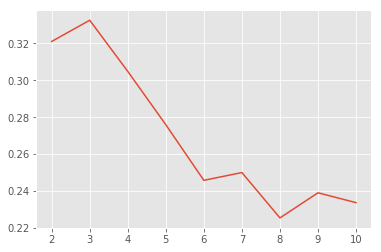

In [239]:
plt.plot(np.arange(2, max_n_clusters+1), optimal_clusters_division(KMeans, scaled_data, max_n_clusters))

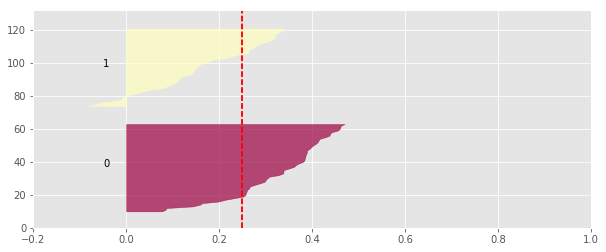

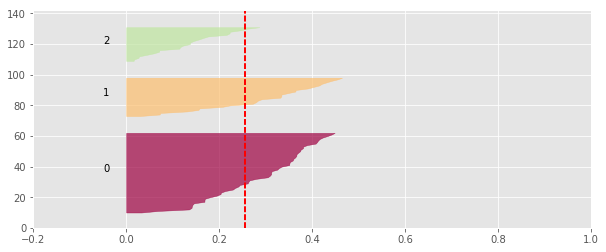

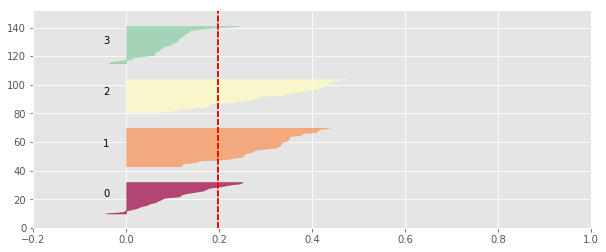

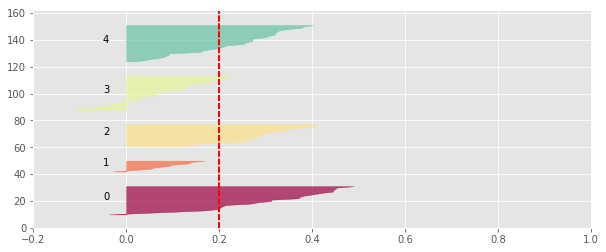

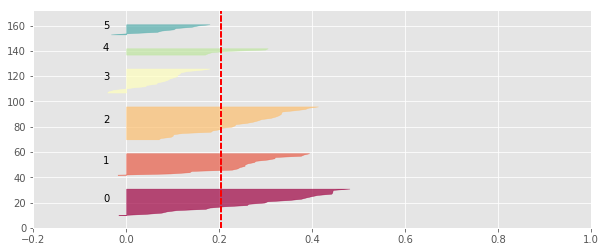

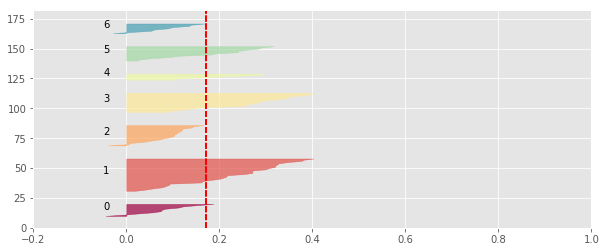

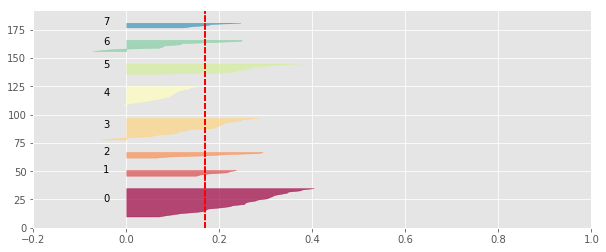

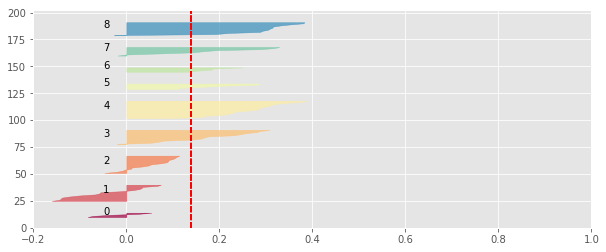

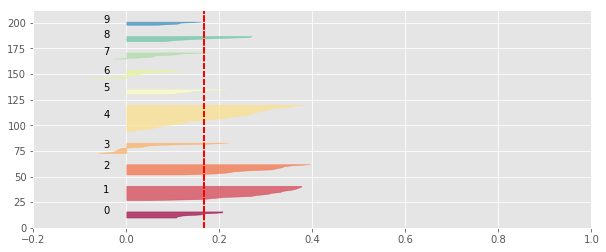

In [240]:
for n_clusters in range(2, max_n_clusters+1):
    plot_silhouette(KMeans(n_clusters=n_clusters), scaled_data.T, n_clusters)

Выбираем разбиение на 8 кластеров

In [241]:
cluster_model = KMeans(n_clusters = 8, random_state = 42)
res = cluster_model.fit_predict(filtered_data)
np.unique(res, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([1356, 1583, 2566, 3015,  520,  922, 1135, 2031], dtype=int64))

In [242]:
cluster_numbers_data = pd.DataFrame(filtered_data.index)
cluster_numbers_data.set_index('dt', inplace=True)
cluster_numbers_data['label'] = res

In [243]:
cluster_numbers_data.head()

,label
dt,
2015-01-01 00:00:00,5
2015-01-01 01:00:00,6
2015-01-01 02:00:00,6
2015-01-01 03:00:00,5
2015-01-01 04:00:00,0


In [244]:
# cluster_numbers_data.to_csv('cluster_labels_feature.csv')

# Оценка набора признаков, подбор модели

При подготовке расчеты были проведены эксперименты по отбору признаков с помощью кластеризации рядов, PCA и дальнейшим решетчатым поиском среди Lasso, Ridge и ElasticNet Regression, RandomForestRegression, ExtremeForestRegression, AdaBoost, XGBoost. Однако, PCA отбор не оправдал надежды - он ускорил вычисления, но ошибка Q_may возвросла до 22.
Из-за негативных результатов, данные выкладки в расчет не включены.

В итоге было принято решение отказаться от PCA и ограничиться решетчатым поиском для Ridge Regression, показавшего себя как наиболее результативный алгоритм среди линейных аналогов.

**Создадим датафреймы с полным набором признаков**

In [245]:
# data.head()

In [246]:
%%time

import warnings
warnings.filterwarnings('ignore')

# Дополним фрейм с общими признаками
data = pd.concat([data, cluster_numbers_data, callendar_data], axis = 1)

linear_models_dict = {}

X_val_dict = {}
y_val_dict = {}
y_val_pred_dict = {}

X_test_dict = {}
y_test_dict = {}
y_test_pred_dict = {}

for id_name in filtered_data.columns:
    print id_name,
    drop_list = list(filtered_data.columns)
    drop_list.remove(str(id_name))
    named_data = data.copy().drop(drop_list, axis = 1) #Избавляемся от лишних id на итерации
    
    #Добавляем shift признаки
    named_data['shift_1'] = named_data[str(id_name)].shift(1)
    named_data['shift_2'] = named_data[str(id_name)].shift(2)
    named_data['shift_3'] = named_data[str(id_name)].shift(3)
    named_data['shift_4'] = named_data[str(id_name)].shift(4)
    named_data['shift_5'] = named_data[str(id_name)].shift(5)
    named_data['shift_6'] = named_data[str(id_name)].shift(6)
    
    named_data['shift_7'] = named_data[str(id_name)].shift(7)
    named_data['shift_8'] = named_data[str(id_name)].shift(8)
    named_data['shift_9'] = named_data[str(id_name)].shift(9)
    named_data['shift_10'] = named_data[str(id_name)].shift(10)
    named_data['shift_11'] = named_data[str(id_name)].shift(11) 
    named_data['shift_12'] = named_data[str(id_name)].shift(12)   
        
    
    named_data['shift_24'] = named_data[str(id_name)].shift(24)
    named_data['shift_48'] = named_data[str(id_name)].shift(48)
    
    named_data = named_data.iloc[48:]
    
    # Разбиение данных
    predict_may_start = '2016-04-30 23:00'
    predict_may_stop = '2016-05-31 23:00'
    precit_june_stop = '2016-06-30 23:00' # df и так заканчивается этим числом
    
    X_train = named_data.loc[:predict_may_start].drop(str(id_name), axis = 1)
    y_train = named_data.loc[:predict_may_start][str(id_name)]
    
    X_val = named_data.loc[predict_may_start:predict_may_stop].drop(str(id_name), axis = 1)
    y_val = named_data.loc[predict_may_start:predict_may_stop][str(id_name)]
    
    X_test = named_data.loc[predict_may_stop:].drop(str(id_name), axis = 1)
    y_test = named_data.loc[predict_may_stop:][str(id_name)]
    
    #Строим Ridge модель с подбором гиперпараметра
    model = linear_model.Ridge()
    param_grid = [{'alpha' : np.logspace(1, 3, 10)}]
    clf = GridSearchCV(model, param_grid, cv = 5)
    best_model = clf.fit(X_train, y_train)
    
    # Сохраним результаты разбиения данных, моделей и их прогнозы по словарям. Ключлм будет являться id региона
    linear_models_dict[id_name] = best_model
    X_val_dict[id_name] = X_val
    y_val_dict[id_name] = y_val
    y_val_pred_dict[id_name] = best_model.predict(X_val)
    X_test_dict[id_name] = X_test
    y_test_dict[id_name] = y_test
    y_test_pred_dict[id_name] = best_model.predict(X_test)


1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168Wall time: 10min 8s



**Анализ Q_may**

In [247]:
may_time_range = pd.date_range('2016-04-30 23:00', '2016-05-31 17:00', freq = 'H')

In [248]:
%%time
Q_may_f = 0
for key in filtered_data.columns:
    print key,
    for date in may_time_range:
        for step in range(1, 7):
            # создадим вспомогательный df для прогноза, чтобы использовать индексы от оригинального df
            forecast = pd.DataFrame(y_val_pred_dict.get(str(key)), index = y_val_dict.get(str(key)).index, columns = ['val'])
            real_values = y_val_dict.get(str(key))
            Q_may_f+= np.abs(forecast.loc[date + timedelta(hours = step)] - real_values.loc[date + timedelta(hours = step)])
Q_may = float(Q_may_f/(102*739*6))
print 
print 'Q_may: ', Q_may

1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168
Q_may:  14.7090939761
Wall time: 3min 56s


Стало лучше

**Анализ Q_june**

In [249]:
june_time_range = pd.date_range('2016-05-31 23:00', '2016-06-30 17:00', freq = 'H')

In [250]:
%%time
Q_june_f = 0
title_list = []
prediction_list = []
for key in filtered_data.columns:
    print key,
    for date in june_time_range:
        for step in range(1, 7):
            # создадим вспомогательный df для прогноза, чтобы использовать индексы от оригинального df
            forecast = pd.DataFrame(y_test_pred_dict.get(str(key)), index = y_test_dict.get(str(key)).index, columns = ['val'])
            real_values = y_test_dict.get(str(key))
#             print forecast
#             print float(forecast.loc[date + timedelta(hours = step)])            
                
            prediction_list.append(float(forecast.loc[date + timedelta(hours = step)]))
            title_list.append(str(key) + '_' + str(date)[:10]+ '_' + str(date.hour) + '_' + str(step))  
            
            Q_june_f+= np.abs(forecast.loc[date + timedelta(hours = step)] - real_values.loc[date + timedelta(hours = step)])
Q_june = float(Q_june_f/(102*739*6))

1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168Wall time: 4min 39s



In [251]:
kaggle_week6_df = pd.DataFrame(prediction_list, index = title_list, columns = ['y'])
kaggle_week6_df.index.name = 'id'
print kaggle_week6_df.shape
kaggle_week6_df.head()

(437580, 1)


,y
id,
1075_2016-05-31_23_1,20.936655
1075_2016-05-31_23_2,14.106473
1075_2016-05-31_23_3,6.242544
1075_2016-05-31_23_4,2.447858
1075_2016-05-31_23_5,5.288216


In [175]:
# kaggle_week6_df.to_csv('kaggle_df_week6.csv')

Ссылка:https://inclass.kaggle.com/c/yellowtaxi/leaderboard